<div class="alert alert-info">
    <h1 align="center">Machine Learning in Python</h1>
    <h3 align="center">Week 06-07: Implementing a Linear Classifier in Python</h3>
    <h5 align="center"><a href="http://www.snrazavi.ir/ml-with-python">Seyed Naser RAZAVI</a></h5>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import layers
from utils.data_utils import load_CIFAR10

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'spline16'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
np.set_printoptions(formatter={'all': lambda x: "%.2f" % x})

# Linear Classification

## Machine Learning Key Ingredients
Any machine learning algorithm is composed of **four key ingredients**: 
- **Data** (Trainig, Test, Validation)
- **Model** or algorithm (Linear, Logistic Regression, Neural Network, Support Vector Machine, etc.)
- **Loss function** (Cross-Enropy, multi-class SVM, SSE, etc.)
- **Optimization method** (Gradient Descent, Mini-batch Gradient Decsent, Adam, RMSprops, etc.)

## Objectives
Today, we will take a look at:
- Linear Classification
- Loss Functions
 - Multi-class SVM Loss function (hinge loss)
 - Multi-class Logistic Regression loss function (cross-entopy or softmax)
- Optimization
- Gradient Descent Algorithm

## CIFAR-10 Data Loading and Preprocessing

In [3]:
from utils.data_utils import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape:   ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape:       ', X_test.shape)
print('Test labels shape:     ', y_test.shape)

Training data shape:    (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:        (10000, 32, 32, 3)
Test labels shape:      (10000,)


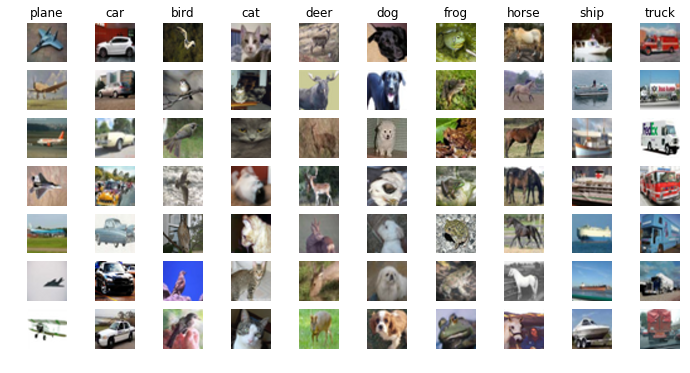

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape:        ', X_train.shape)
print('Train labels shape:      ', y_train.shape)
print('Validation data shape:   ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape:         ', X_test.shape)
print('Test labels shape:       ', y_test.shape)

Train data shape:         (49000, 32, 32, 3)
Train labels shape:       (49000,)
Validation data shape:    (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:          (1000, 32, 32, 3)
Test labels shape:        (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape:   ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape:       ', X_test.shape)
print('dev data shape:        ', X_dev.shape)

Training data shape:    (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:        (1000, 3072)
dev data shape:         (500, 3072)


[130.64 135.98 132.47 130.06 135.35 131.75 130.96 136.14 132.48 131.48]


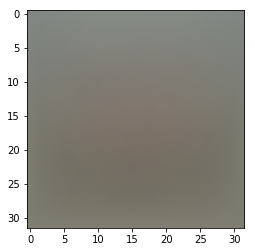

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val   -= mean_image
X_test  -= mean_image
X_dev   -= mean_image

## Parametric Classification
- In any parametric method, there are a **fixed set of parameters**.
- The goal of learning is to **determine the best possible values** for these parameters.
- After learning parameters from data, we can predict for new data **using only these parameters**.

## Score function
Earlier, we said that in supervised learning, we have a training dataset such as:

$$\{(x^{(1)}, y^{(1)}),(x^{(2)}, y^{(2)}),\dots,(x^{(N)}, y^{(N)})\}$$

and, we are looking for a function (hypothesis) from input features to the target values, as following:

$$h: X \to Y $$

Here, our approach will have two major components: 
- a **score function** that maps the raw data to class scores, and
- a **loss function** that quantifies the agreement between the predicted scores and the ground truth labels. 

We will then cast this as an optimization problem in which we will minimize the loss function with respect to the parameters of the score function.

<img src="http://www.snrazavi.ir/imgs/linear1.png" width="100%"/>

### Linear score function

<img src="http://www.snrazavi.ir/imgs/Linear2.png" width="100%"/>

**Linear classifier.** 
- We will start out with the simplest possible function, a linear mapping:

$$f(x_i,W,b)=Wx_i+b$$

**Assumptions.**
- The image $x_i$ has all of its pixels flattened out to a single column vector of shape [D x 1]. 
- The matrix W (of size [K x D]), and the vector b (of size [K x 1]) are the parameters of the function. 

**Example.**
- In CIFAR-10, $x_i$ contains all pixels in the i-th image flattened into a single [3072 x 1] column, 
- W is [10 x 3072] and b is [10 x 1], 
- So, 3072 numbers come into the function (the raw pixel values) and 10 numbers come out (the class scores). 

The parameters in W are often called the **weights**, and b is called the **bias** vector because it influences the output scores, but without interacting with the actual data $x_i$. 

<img src="http://www.snrazavi.ir/imgs/Linear3.png" width="100%"/>

<div class="alert alert-warning">
    <b>Quetion?</b>
    <ul>
        <li> Considering the above figure, are the given values for the parameters are good values?
        </li>
    </ul>
</div>

#### Bias trick

<img src="http://www.snrazavi.ir/imgs/wb.jpeg" width="80%"/>

## Geometric Interpretation

**Analogy of images as high-dimensional points.** 
- Since the images are stretched into high-dimensional column vectors, we can interpret each image as a single point in this space.
- For example, each image in CIFAR-10 is a point in 3072-dimensional space of 32x32x3 pixels.

<img src="http://www.snrazavi.ir/imgs/Linear_4.png" width="100%"/>

**Geometric interpretation.**
- Every row of $W$ is a classifier for one of the classes (a *hyper-plane*).
- As we change one of the rows of $W$, the corresponding line in the pixel space will rotate in different directions. 
- The biases $b$, allow our classifiers to translate the lines. 

## Linear Classification: Another Interpretation

<img src="http://www.snrazavi.ir/imgs/LinearClassification_prototypes.png" width="100%"/>

**Interpretation of linear classifiers as template matching.**
- Another interpretation: each row of $W$ corresponds to a **template** (or *prototype*) for one of the classes. 
- Inner product: the score of each class for an image is then obtained by comparing each template with the image using an **inner product** (or *dot product*) one by one to find the one that “fits” best. 
- With this terminology, the linear classifier is doing **template matching**, where the templates are learned. 

## Defining a Linear Layer: Forward Step

In [9]:
def affine_forward(x, W, b):
    """
    A linear mapping from inputs to scores.
    
    Inputs:
        - x: input matrix (N, d1, d2, ...dn)
        - W: weigh matrix (D, C)
        - b: bias vector  (C, )
    
    Outputs:
        - out: output of linear layer (N, C)
    """
    x2d = np.reshape(x, (x.shape[0], -1))  # convert 4D input matrix to 2D    
    out = np.dot(x2d, W) + b               # linear transformation
    cache = (x, W, b)                      # keep for backward step (stay with us)
    return out, cache

## Linear Classification Demo

For a better understanding of what exactly a linear classification does, we suggest you to take a look at a very useful demo from Stanford at [this address](http://vision.stanford.edu/teaching/cs231n-demos/linear-classify/).

<a href="http://vision.stanford.edu/teaching/cs231n-demos/linear-classify/">
<img src="http://www.snrazavi.ir/imgs/classifydemo.jpeg" width="90%"/>
</a>

# Loss Function

**Loss Function.** (sometimes called *cost* function or *objective*)
- A measure which tells the machine how much the current parameters are bad.
- Intuitively, the loss will be high if the parameters are doing a poor job of classifying the training data, and it will be low if they are doing well.

<img src="http://www.snrazavi.ir/imgs/loss.png" width="60%"/>

## Multi-class SVM Loss Function

Computing loss for a single training data $(x_i, y_i)$.

We want ($\forall j \ne y_i$):

### $$s_{y_i} \ge s_j+1$$

or, equivlently:

### $$s_j - s_{y_i} + 1 \le 0$$


<img src="http://www.snrazavi.ir/imgs/svm-loss.jpg" width="100%"/>

#### Margins

<img src="http://www.snrazavi.ir/imgs/margin.jpg" width="60%"/>

### Unvectorized implementation

In [10]:
def L_i(x, y, W):
    """
    unvectorized version. Compute the multiclass svm loss for a single example (x,y)
    - x is a column vector representing an image (e.g. 3073 x 1 in CIFAR-10)
      with an appended bias dimension in the 3073-rd position (i.e. bias trick)
    - y is an integer giving index of correct class (e.g. between 0 and 9 in CIFAR-10)
    - W is the weight matrix (e.g. 10 x 3073 in CIFAR-10)
    """
    scores = W.dot(x) # scores becomes of size 10 x 1, the scores for each class
    correct_class_score = scores[y]
    C = W.shape[0] # number of classes, e.g. 10
    
    loss_i = 0.0
    for j in range(C): # iterate over all wrong classes
        if j == y:
            # skip for the true class to only loop over incorrect classes
            continue
        # accumulate loss for the i-th example
        loss_i += max(0, scores[j] - correct_class_score + 1.0)
    return loss_i

### Half-vectorized implementation

In [11]:
def L_i_vectorized(x, y, W):
    """
    A faster half-vectorized implementation. 
    Half-vectorized refers to the fact that for a single example the implementation contains
    no for loops, but there is still one loop over the examples (outside this function)
    """
    scores = W.dot(x)
    margins = np.maximum(0, scores - scores[y] + 1.0)
    margins[y] = 0  # cancel the correct class loss
    loss_i = np.sum(margins)
    return loss_i


<img src="http://www.snrazavi.ir/imgs/svm_half_vectorized.jpg" width="100%"/>

### Fully vectorized implementation

<div class="alert alert-success">
    <b>Excersize:</b> multi-class SVM loss function
    <ul>
        <li> Implement the fully vectorized multi-class SVM loss function for the training dataset.
        </li>
    </ul>
</div>

In [12]:
def L(X, y, W):
    """
    fully-vectorized implementation :
    - X holds all the training examples as rows (e.g. 50,000 x 3073 in CIFAR-10)
    - y is array of integers specifying correct class (e.g. 50,000-D array)
    - W are weights (e.g. 3073 x 10)
    """
    # evaluate loss over all examples in X without using any for loops    
    # left as exercise to reader in the assignment
    # ...

<div class="alert alert-warning">
    <b>Quetion?</b> Sanity check!
    <ul>
        <li> Is there any way to be sure that your loss function implementation is correct?</li>
        <li> Think what happens to scores when we initialize parameters with very tiny numbers?</li>

    </ul>
</div>

In [13]:
# create W and b randomly with small numbers
N = X_train.shape[0]           # number of training data
D = np.prod(X_train.shape[1:]) # number of features
C = 10                         # number of classes

# init parameters
W = 0.0001 * np.random.randn(D, C)
b = np.zeros((C,))

### Sanity check for loss function

In [14]:
from utils.layers import affine_forward, svm_loss_naive

In [15]:
scores, _ = affine_forward(X_train, W, b)
loss, _ = svm_loss_naive(scores, y_train)

print("Data loss = %.2f" % loss)

Data loss = 9.42


**Note:** When using SVM loss, the value of loss function with randomly initialized weights, must be approximately equal to the number of classes minus one. (Why?)
- For example, in CIFAR-10, there are 10 classes, and hence, the above value must be near to 9.

#### Example: Computing loss for first training data

In [16]:
print("scores = ", scores[0])
print("correct class score = %.2f" % scores[0][y_train[0]])

scores =  [-0.11 -0.14 0.20 0.41 -0.24 0.34 -0.18 -0.27 -0.46 0.28]
correct class score = -0.18


In [17]:
i = 0  # first training data
margins = scores[i] - scores[i][y_train[i]] + 1.0
margins[y_train[i]] = 0.0

print(margins)
print(np.sum(np.maximum(0.0, margins)))

[1.07 1.04 1.38 1.59 0.94 1.52 0.00 0.91 0.72 1.47]
10.6498941006


## Regularization (Weight Decay)
- Don't let the weights to become **too large**.
- This will result in a more smooth hypothesis, with **better performance on new data**.

For more information about regularization, please see [Regularization](https://youtu.be/dIP2Y0F5tjY).

<img src="http://www.snrazavi.ir/imgs/regularization_loss.jpg" width="80%"/>

In [18]:
reg = 1e3  # regularization strength

loss, _ = svm_loss_naive(scores, y_train)  # data loss
loss += 0.5 * reg * np.sum(W * W)

print("Loss (data loss + regularization loss) = %.2f" % loss)

Loss (data loss + regularization loss) = 9.57


Note that the loss value has increased because of adding regularization.

### Fully-vectorized loss function

In [19]:
from utils.layers import svm_loss

loss, _ = svm_loss(scores, y_train)  # data loss
loss += 0.5 * reg * np.sum(W * W)  # regularization loss

print("Loss = %.2f" % loss)

Loss = 9.57


### Vetorized vs. Unvectorized implemetation: comparing efficiencies

In [20]:
import time

# time of naive implementation (two-loop version)
tic = time.time()
loss_naive, _ = svm_loss_naive(scores, y_train)
toc = time.time()
naive_time = toc - tic
print('Naive loss: \t %.5f computed in %fs' % (loss_naive, naive_time))

# time of fully vectorized implementation (no-loop version)
tic = time.time()
loss_vectorized, _ = svm_loss(scores, y_train)
toc = time.time()
vec_time = toc - tic
print('Vectorized loss: %.5f computed in %fs' % (loss_vectorized, vec_time))

# The losses should match but your vectorized implementation should be much faster.
print('difference: \t %f' % (loss_naive - loss_vectorized))
print('ratio: \t\t %f' % (naive_time / vec_time))

Naive loss: 	 9.41783 computed in 0.395285s
Vectorized loss: 9.41783 computed in 0.035595s
difference: 	 0.000000
ratio: 		 11.104944


---

## Multi-class Logistic Regression Loss Function

<img src="http://www.snrazavi.ir/imgs/cross_entropy_loss.jpg" width="80%"/>

In [21]:
scores = np.array([3.2, 5.1, -1.7])

# Exponentiation
exp_scores = np.exp(scores)

# Normalization
probs = exp_scores / np.sum(exp_scores)

print("scores:       ", scores)
print("exp scores:   ", exp_scores)
print("probabilities:", probs)

scores:        [3.20 5.10 -1.70]
exp scores:    [24.53 164.02 0.18]
probabilities: [0.13 0.87 0.00]


### Cross Entropy
- Measuring distance between two distributions.

<img src="http://www.snrazavi.ir/imgs/cross_entropy_formula.jpg" width="80%"/>

#### A useful trick: preventing overflow and underflow
- If the values of the scores are large, then the exponetiation may result in **overflow/underflow**.
- So, we can always **subtract the maximum score** from all the scores

``` python
# subtract maximum score from scores
scores -= np.max(scores)  # note: here, scores are 1D array
```

$$p_i = \frac{\exp(s_{y_i}+C)}{\sum_j{\exp(s_j+C)}} = \frac{\exp(C) \times \exp(s_{y_i})}{\sum_j{exp(C) \times \exp(s_j)}} = \frac{\exp(s_{y_i})}{\sum_j{\exp(s_j)}}$$

$p_i$ represents the probabilities (logits) for ith data $x_i$, and $C$ is any given constant. It is obvious that we can replace the constant $C$ with maximum score. 

In [22]:
# subtract maximum
scores -= np.max(scores)

# Exponentiation
exp_scores = np.exp(scores)

# Normalization
probs = exp_scores / np.sum(exp_scores)

print("scores:       ", scores)
print("exp scores:   ", exp_scores)
print("probabilities:", probs)

scores:        [-1.90 0.00 -6.80]
exp scores:    [0.15 1.00 0.00]
probabilities: [0.13 0.87 0.00]


#### Example: Overflow

In [23]:
scores = np.array([1000, 1001, 1002])

# subtract maximum
scores -= np.max(scores)  # comment this line to see overflow

# Exponentiation
exp_scores = np.exp(scores)

# Normalization
probs = exp_scores / np.sum(exp_scores)

print("scores:       ", scores)
print("exp scores:   ", exp_scores)
print("probabilities:", probs)

scores:        [-2.00 -1.00 0.00]
exp scores:    [0.14 0.37 1.00]
probabilities: [0.09 0.24 0.67]


### Softmax loss function: Naive implementation

In [24]:
from utils.layers import softmax_loss_naive

In [25]:
# Initialize parameters randomly
W = 0.0001 * np.random.randn(3072, 10)  # for cifar10
b = np.zeros((10,))

In [26]:
# compute linear scores
scores, _ = affine_forward(X_train, W, b)

In [27]:
# compute data loss
loss, _ = softmax_loss_naive(scores, y_train)
print("loss = %.2f" % loss)

loss = 2.34


<div class="alert alert-warning">
    <b>Quetion?</b> Sanity check!
    <ul>
        <li> Is there any way to be sure that your loss function implementation is correct?</li>
        <li> Think what happens to scores when we initialize parameters with very tiny numbers?</li>
    </ul>
</div>

In [28]:
s = np.array([0.0, 0.0, 0.0])

# subtract maximum
s -= np.max(s)

# Exponentiation
exp_s = np.exp(s)

# Normalization
probs = exp_s / np.sum(exp_s)

print("scores:       ", s)
print("exp scores:   ", exp_s)
print("probabilities:", probs)

scores:        [0.00 0.00 0.00]
exp scores:    [1.00 1.00 1.00]
probabilities: [0.33 0.33 0.33]


In [29]:
# Sanity Check
print("log(10) = %.2f" % np.log(10))  # NATURAL LOGRAITHM

log(10) = 2.30


### Softmax loss function: Vectorized implementation

In [30]:
from utils.layers import softmax_loss

loss, _ = softmax_loss(scores, y_train)
print("loss = %.2f" % loss)

loss = 2.34


### Vectorized vs. Unvectorized implementation: comparing efficiencies

In [31]:
import time

# time of naive implementation (two-loop version)
tic = time.time()
loss_naive, _ = softmax_loss_naive(scores, y_train)
toc = time.time()
time_naive = toc - tic
print('Naive loss: \t %.5f computed in %fs' % (loss_naive, time_naive))

# time of fully vectorized implementation (no-loop version)
tic = time.time()
loss_vectorized, _ = softmax_loss(scores, y_train)
toc = time.time()
time_vec = toc - tic
print('Vectorized loss: %.5f computed in %fs' % (loss_vectorized, time_vec))

# The losses should match but your vectorized implementation should be much faster.
print('difference: \t %f' % (loss_naive - loss_vectorized))
print('ratio: \t\t %.2f' % (time_naive / time_vec))

Naive loss: 	 2.34340 computed in 9.462505s
Vectorized loss: 2.34340 computed in 0.038616s
difference: 	 -0.000000
ratio: 		 245.04


# Optimization: Minimizing Loss Function

- Now, he have a loss function which measures how **bad** the parameters are.
- Therefore, we can find **best parameters** by minimizing the loss function.

## Gradient Descent Algorithm

<img src="http://www.snrazavi.ir/imgs/gradient_descent_line_graph.gif" width="100%"/>

### Gradient Descent algorithm: math

<img src="http://www.snrazavi.ir/imgs/gradient_descent_fig.jpg" width="70%"/>

<div class="alert alert-success">
    <h3>Gradient Descent Algorithm</h3>
    <ol>
        <li>Start with random initial parameters</li>
        <li>At each iteration:</li>
        <ol>
            <li>Compute the gradient of loss function w.r.t. parameters</li>
            <li>Update parameters: $W^{(new)} \leftarrow W^{(old)} - \alpha * \nabla_w L(W)$</li>
        </ol>
    </ol>
</div>

``` python
# Step1: initialize weights using small random numbers
W = 0.0001 * np.random.randn(D, C)
    
# Step 2: loop until convergence
while True:
    dW = evaluate_gradients(loss_function, X_train, y_train, W)  # dW is dL/dW
    W = W - learning_rate * dW
```

### Mini-batch gradient descent
- The gradient descent algorithm is **very inefficient** when the training data is very big.
- So, at each iteration, we use only a **small random fraction of training data (batch)**. 

<div class="alert alert-success">
    <h3>Mini-batch Gradient Descent Algorithm</h3>
    <ol>
        <li>Start with random initial parameters</li>
        <li>At each iteration:</li>
        <ol>
            <li><b>Select a batch of data randomly</b></li>
            <li>Compute the gradient of loss function w.r.t. parameters</li>
            <li>Update parameters: $W^{(new)} \leftarrow W^{(old)} - \alpha * \nabla_w L(W)$</li>
        </ol>
    </ol>
</div>

``` python
# Step1: initialize weights using small random numbers
W = 0.0001 * np.random.randn(D, C)
    
# Step 2: loop until convergence
while True:
    X_batch, y_batch = sample_training_data(X_train, y_train, batch_size=256)
    dW = evaluate_gradients(loss_function, X_batch, y_batch, W)  # dW is dL/dW
    W = W - learning_rate * dW
```

## Backpropagation
- BP is an efficient way of computing gradients automatically w.r.t. parameter, inputs and any intermediate results.
- The only requirement to use BP is that we should provide a **backward** function for each layer we define, so that this function takes the gradients with respects to its outputs and computes the gradients with respect to its inputs using **Chain Rule**.

**Chain Rule.** Let assume that $y=g(f(x))$. Then, we have:

$$\frac{dg}{dx} = \frac{dg}{df} \times \frac{df}{dx}$$

<img src="http://www.snrazavi.ir/imgs/backward_gradient.jpg" width="60%"/>

#### Forward step

```python
def affine_forward(x, w, b):
    x2d = np.reshape(x, (x.shape[0], -1))  # convert x to a 2D array
    out = np.dot(w, x2d) + b
    cache = (x, w, b)
    return out, cache
```

#### Backward Step

```python
def affine_backward(dout, cache):
    """Backward step for a linear layer.
       
       Inputs:
           - dout: the upstream dervatives; i.e., partial dervative of loss w.r.t. out.
           - cache: a tuple containing the inputs of a linear layer (x, w, b)
           
       Outputs:
           - dx: derevative of loss function w.r.t. x
           - dw: derevative of loss function w.r.t. w
           - db: derevative of loss function w.r.t. b
    """
    x, w, b = cache 
    # compute dx (dL/dx = dL/dout * dout/dx)
    # compute dW (dL/dw = dL/dout * dout/dw)
    # compute db (dL/db = dL/dout * dout/db)
    return dx, dw, db
```

### Computing gradients of loss function

$$L_i=-\log(p_{y_i}) = -\log(\frac{\exp(s_{y_i})}{\sum_j{\exp(s_j)}}) = \log(\sum_j{\exp(s_j)}) - s_{y_i}$$

#### Computing partial derevative w.r.t. $s_j$ for $j \ne y_i$

$$\frac{\partial L_i}{\partial s_j} = \frac{\exp(s_j)}{\sum_j{\exp(s_j)}} = p_j $$

#### Computing partial derevative w.r.t. $s_{y_i}$

$$\frac{\partial L_i}{\partial s_{y_i}} = \frac{\exp(s_{y_i})}{\sum_j{\exp(s_j)}} - 1 = p_{y_i} - 1$$

In [32]:
def softmax_loss(s, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - s: Input data, of shape (N, C) where s[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    
    # forward step: computing data loss
    shifted_logits = s - np.max(s, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = s.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    
    # backward step: computing gradient of loss w.r.t. s (scores).
    ds = probs.copy()
    ds[np.arange(N), y] -= 1
    ds /= N
    return loss, ds

In [33]:
def svm_loss(s, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - s: Input data, of shape (N, C) where s[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    
    # forward step: computing data loss
    N = s.shape[0]
    correct_class_scores = s[np.arange(N), y]
    margins = np.maximum(0, s - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    
    # backward step: computing gradient of loss w.r.t. s (scores).
    num_pos = np.sum(margins > 0, axis=1)
    ds = np.zeros_like(s)
    ds[margins > 0] = 1
    ds[np.arange(N), y] -= num_pos
    ds /= N
    return loss, ds

# Putting All Together: Data + Model + Loss + Optimization

## Data: `CIFAR-10`
- Our data is ready, as we have done all necessary pre-processing steps.

In [34]:
print('Training data shape:   ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape:       ', X_test.shape)
print('dev data shape:        ', X_dev.shape)

Training data shape:    (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:        (1000, 3072)
dev data shape:         (500, 3072)


## Model: `linear model`
- for data $(x_i, y_i)$, compute the score using: 
$$f(x_i, W, b)=Wx_i + b$$

## Loss function: `Cross-Enropy`
- From score, compute probabilities using `softmax` function.
- Compute loss for each data using the computed probilities and its true label.

$$L_i=-\log(p_{y_i})$$

- Compute the total loss as the average over all the data losses plus regularization loss.

$$L = \frac{1}{N} \sum_{i=1}^N{L_i} + \lambda \sum_{jk}W_{jk}^2$$

**Note**: Remember to use *vectorized implementation*, which is computationally much more efficient.

## Minimize Loss Function: `Gradient Descent`

In [35]:
from utils.layers import affine_backward

In [36]:
N = X_train.shape[0]

# define parameters for mini-batch GD
num_iterations = 1500
batch_size = 256
learning_rate = 1e-7
reg = 2.5e4

# initialize weights
W = 0.0001 * np.random.randn(3072, 10)
b = np.zeros(10)

loss_history = []

for i in range(num_iterations + 1):
    # create a batch of data
    batch_idxs = np.random.choice(N, batch_size, replace=False)
    X_batch = X_train[batch_idxs]
    y_batch = y_train[batch_idxs]
    
    # forward step
    scores, cache = affine_forward(X_batch, W, b)
    
    # compute loss
    loss, dscores = softmax_loss(scores, y_batch)  # data loss
    loss += 0.5 * reg * np.sum(W * W)          # regularization loss
    loss_history.append(loss)
    
    # backward step
    _, dW, db = affine_backward(dscores, cache)
    dW += reg * W
      
    # report every 100 iteration
    if i % 100 == 0:
        y_preds = np.argmax(scores, axis=1)
        train_accuracy = 100.0 * np.mean(y_preds == y_batch)
        
        val_scores, _ = affine_forward(X_val, W, b)
        val_preds = np.argmax(val_scores, axis=1)
        val_accuracy = 100.0 * np.mean(val_preds == y_val)
        print("Iteration %4d: loss = %5.2f | train accuracy = %5.2f | validation accuracy = %5.2f" % 
             (i, loss, train_accuracy, val_accuracy))
    
    # update rule
    W = W - learning_rate * dW
    b = b - learning_rate * db

Iteration    0: loss =  6.18 | train accuracy =  8.59 | validation accuracy =  8.90
Iteration  100: loss =  4.40 | train accuracy = 28.52 | validation accuracy = 27.20
Iteration  200: loss =  3.44 | train accuracy = 32.81 | validation accuracy = 31.40
Iteration  300: loss =  2.93 | train accuracy = 32.42 | validation accuracy = 32.90
Iteration  400: loss =  2.49 | train accuracy = 35.55 | validation accuracy = 33.40
Iteration  500: loss =  2.35 | train accuracy = 30.86 | validation accuracy = 34.60
Iteration  600: loss =  2.08 | train accuracy = 42.97 | validation accuracy = 35.60
Iteration  700: loss =  2.13 | train accuracy = 37.50 | validation accuracy = 35.90
Iteration  800: loss =  2.09 | train accuracy = 37.50 | validation accuracy = 35.40
Iteration  900: loss =  2.07 | train accuracy = 33.98 | validation accuracy = 35.60
Iteration 1000: loss =  1.99 | train accuracy = 36.72 | validation accuracy = 36.60
Iteration 1100: loss =  2.03 | train accuracy = 36.33 | validation accuracy 

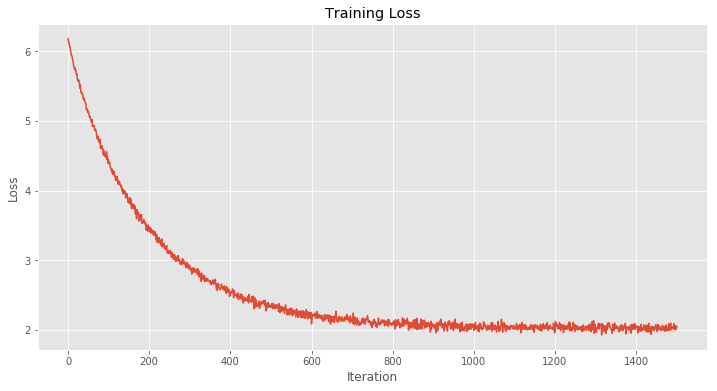

In [37]:
plt.style.use('ggplot')

plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss');

### Visulalize weights

In [38]:
print(W.shape)

(3072, 10)


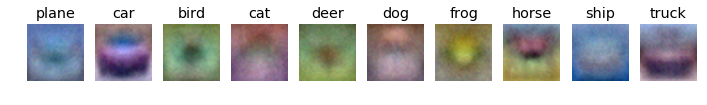

In [39]:
w_min, w_max = np.min(W), np.max(W)

for i, label in enumerate(classes):
    w = W[:, i]
    w = np.reshape(w, (32, 32, 3))
    w = 255.0 * (w - w_min) / (w_max - w_min)
    plt.subplot(1, 10, i + 1)
    plt.imshow(w.astype('uint8'), interpolation='spline16')
    plt.axis('off')
    plt.title(label)

### Prediction on test data

In [40]:
def predict(x, W, b):
    scores, _ = affine_forward(x, W, b)
    return np.argmax(scores, axis=1)

In [41]:
test_pred = predict(X_test, W, b)
test_accuracy = 100.0 * np.mean(test_pred == y_test)
print("Test accuracy = %.2f" % test_accuracy)

Test accuracy = 36.10


#### Predict labels for 10 randomly chosen test data

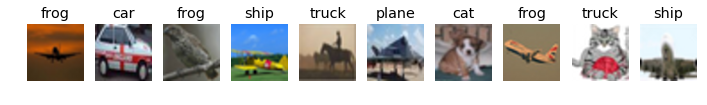

In [42]:
# choose 10 random test data
num_samples = 10
idxs = np.random.choice(X_test.shape[0], num_samples, replace=False)
X_sample, y_sample = X_test[idxs], y_test[idxs]

# predict labels
y_pred = predict(X_sample, W, b)

# To draw the picture, we should add back the mean
X_sample += mean_image

for i in range(num_samples):
    x, y = X_sample[i, :], y_sample[i]
    x = x.reshape((32, 32, 3))
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(x.astype('uint8'))
    plt.axis('off')
    plt.title(classes[y_pred[i]]);